# Cronavirus cases correlation

In [116]:
# update data
!git submodule update
!cd COVID-19/; git pull

remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 966 (delta 453), reused 491 (delta 435), pack-reused 456
Receiving objects: 100% (966/966), 7.51 MiB | 3.10 MiB/s, done.
Resolving deltas: 100% (509/509), completed with 20 local objects.
From https://github.com/CSSEGISandData/COVID-19
   0cea9b2..e69d4ce  master     -> origin/master
   33e9e3b..8690640  web-data   -> origin/web-data
Updating 0cea9b2..e69d4ce
Fast-forward
 .../time_series_19-covid-Confirmed.csv             | 682 +++++++++++----------
 .../time_series_19-covid-Deaths.csv                | 682 +++++++++++----------
 .../time_series_19-covid-Recovered.csv             | 682 +++++++++++----------
 3 files changed, 1044 insertions(+), 1002 deletions(-)


In [117]:
import pandas as pd
import pylab

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8] # w, h

min_number_cases=100
min_number_cases_date='3/10/20'  # today date
zero_ref=100

data_folder = "./COVID-19/csse_covid_19_data/csse_covid_19_time_series"
file_name = {
    "confirmed": "{}/time_series_19-covid-Confirmed.csv".format(data_folder),
    "death": "{}/time_series_19-covid-Deaths.csv".format(data_folder),
    "recover": "{}/time_series_19-covid-Recovered.csv".format(data_folder)
}

In [118]:
def process_df(df, zero_ref=100):
    data = {}
    for country, row in df.iterrows():
        cases = row.to_list()
        new_i, zero_i = 0, 0
        start = False
        for i in range(len(cases)):
            if row[i] >= zero_ref:
                zero_i = i
                break
        new_i = [i-zero_i for i in range(len(cases))]
        data[country] = {"cases": cases, "index": new_i}
    return data    
    
def plot_dict(dict_c, xlim, xlabel, ylabel, titlestr):
    fig = plt.figure()
    plt.title(titlestr)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = fig.add_subplot(1, 1, 1)
    for country in dict_c:
        y, x = dict_c[country]["cases"], dict_c[country]["index"]
        #plt.plot(x, y, '.-', linewidth=2, markersize=12)
        if country == 'US':
            line, = ax.plot(x, y, '*--', lw=1, color='r', label=country)
        else:
            line, = ax.plot(x, y, '.-', lw=2, label=country)
    ax.grid(which='both', b=True)
    ax.set_xlim(-xlim,+xlim)
    ax.legend()
    ax.set_yscale('log')
    pylab.show()

def plot_csv_file(file_type, min_number_cases=150, min_number_cases_date='3/6/20', zero_ref=100, xlim=15):
    file_path = file_name[file_type]
    df_c = pd.read_csv(file_path) 
    print(df_c.head())
    df_c = df_c.drop(['Lat', 'Long', 'Province/State'], axis=1)
    df_c = df_c.groupby(['Country/Region']).sum()
    df_c = df_c.loc[df_c[min_number_cases_date] >= min_number_cases]
    
    df_dict = process_df(df_c, zero_ref)
    
    titlestr = file_type
    xlabel = 'days since {} number of people {}'.format(min_number_cases, file_type)
    ylabel = 'people number'
    plot_dict(df_dict, xlim, xlabel, ylabel, titlestr)
    

  Province/State  Country/Region      Lat      Long  1/22/20  1/23/20  \
0          Anhui  Mainland China  31.8257  117.2264        1        9   
1        Beijing  Mainland China  40.1824  116.4142       14       22   
2      Chongqing  Mainland China  30.0572  107.8740        6        9   
3         Fujian  Mainland China  26.0789  117.9874        1        5   
4          Gansu  Mainland China  36.0611  103.8343        0        2   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  3/1/20  3/2/20  3/3/20  3/4/20  \
0       15       39       60       70  ...     990     990     990     990   
1       36       41       68       80  ...     413     414     414     418   
2       27       57       75      110  ...     576     576     576     576   
3       10       18       35       59  ...     296     296     296     296   
4        2        4        7       14  ...      91      91      91      91   

   3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  
0     990     990     990     990     9

/Users/haoyuhe/work/fastquant/goquant/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


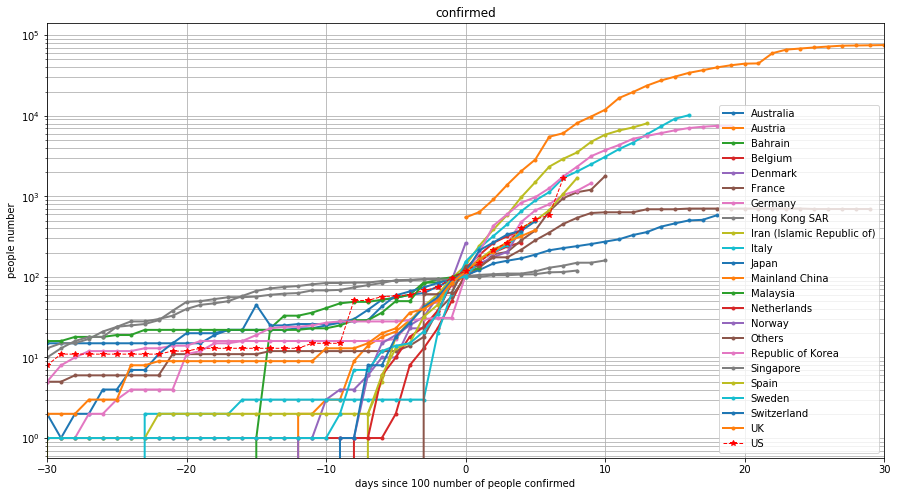

In [119]:
plot_csv_file("confirmed",
              min_number_cases=min_number_cases, 
              min_number_cases_date=min_number_cases_date, 
              zero_ref=zero_ref,
             xlim=30)

  Province/State  Country/Region      Lat      Long  1/22/20  1/23/20  \
0          Anhui  Mainland China  31.8257  117.2264        0        0   
1        Beijing  Mainland China  40.1824  116.4142        0        0   
2      Chongqing  Mainland China  30.0572  107.8740        0        0   
3         Fujian  Mainland China  26.0789  117.9874        0        0   
4          Gansu  Mainland China  36.0611  103.8343        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  3/1/20  3/2/20  3/3/20  3/4/20  \
0        0        0        0        0  ...     873     917     936     956   
1        1        2        2        2  ...     276     282     288     297   
2        0        0        0        0  ...     450     469     490     502   
3        0        0        0        0  ...     247     255     260     270   
4        0        0        0        0  ...      84      85      86      87   

   3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  
0     970     979     979     984     9

/Users/haoyuhe/work/fastquant/goquant/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


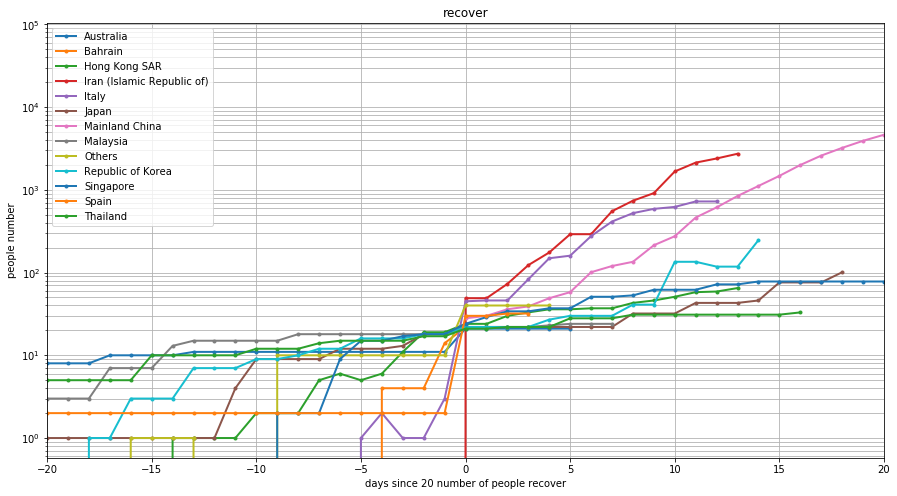

In [120]:
plot_csv_file("recover",
              min_number_cases=20, 
              min_number_cases_date=min_number_cases_date, 
              zero_ref=20,
             xlim=20)

  Province/State  Country/Region      Lat      Long  1/22/20  1/23/20  \
0          Anhui  Mainland China  31.8257  117.2264        0        0   
1        Beijing  Mainland China  40.1824  116.4142        0        0   
2      Chongqing  Mainland China  30.0572  107.8740        0        0   
3         Fujian  Mainland China  26.0789  117.9874        0        0   
4          Gansu  Mainland China  36.0611  103.8343        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  3/1/20  3/2/20  3/3/20  3/4/20  \
0        0        0        0        0  ...       6       6       6       6   
1        0        0        0        1  ...       8       8       8       8   
2        0        0        0        0  ...       6       6       6       6   
3        0        0        0        0  ...       1       1       1       1   
4        0        0        0        0  ...       2       2       2       2   

   3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  
0       6       6       6       6      

/Users/haoyuhe/work/fastquant/goquant/env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


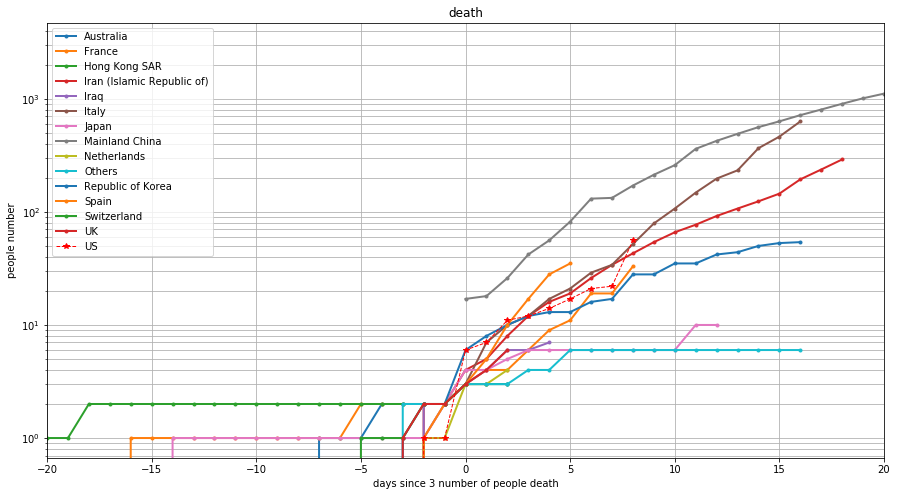

In [121]:
plot_csv_file("death",
              min_number_cases=3, 
              min_number_cases_date=min_number_cases_date, 
              zero_ref=3,
             xlim=20)